### Start a spark session

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.jars.packages", "io.delta:delta-sharing-spark_2.12:3.3.0") \
    .getOrCreate()

### List Tables
Use the provided config

In [2]:
import delta_sharing
config = "work/config.share"
client = delta_sharing.SharingClient(config)
client.list_all_tables()

[Table(name='ev3_device_data', share='start_hack_2025', schema='start_hack_2025'),
 Table(name='cc_api_logs', share='start_hack_2025', schema='start_hack_2025'),
 Table(name='ev3_dataprofile', share='start_hack_2025', schema='start_hack_2025')]

### Table 1
Energyvalve 3 dataprofile describing the datapoints found in the device data table.

In [12]:
import pandas as pd
df = spark.read.format("deltaSharing").load(f"{config}#start_hack_2025.start_hack_2025.ev3_dataprofile")

In [13]:
df.columns

['id',
 'access',
 'basetype',
 'description',
 'format',
 'name',
 'privacy',
 'restriction',
 'definedBy',
 'unit']

### Table 2
Energyvalve 3 device data. **Big data** list of timeseries samples for devices. Devices are differentiated by the **device_id** column.

In [3]:
df2 = spark.read.format("deltaSharing").load(f"{config}#start_hack_2025.start_hack_2025.ev3_device_data") # .limit(3)

In [4]:
df2.head(2)

[Row(device_id='14e5bc06-9e32-4938-96df-82a070581e7d', dataprofile_id='energyvalve3/1.11', cloud_received_time=datetime.datetime(2019, 6, 9, 9, 40, 34, 98000), sample_time=datetime.datetime(2019, 6, 9, 9, 38, 32, 312000), year='2019', year_month='201906', year_month_day='20190609', influx_migration_source_filename='2019-06-09_09.gz', T1_remote_K=349.9248691099477, T2_embeded_K=323.42526041666656, RelFlow_Fb_Rel2Vmax=94.32536203404179, RelPower_Fb_Rel2Pmax=3101.045820664627, AbsFlow_Fb_m3s=0.0028297608610212536, AbsPower_Fb_W=310104.5820664627, Heating_E_J=0.0, Glycol_Concentration_Rel=0.0, ControlMode_Write=1, Cooling_E_J=1035416377217.5392, RelPos_Fb=92.03, DeltaT_Limitation_Write=2, SpDeltaT_K_Write=10.0, Pmax_Rel_Write=0.5882352941176471, Vmax_Rel_Write=37.5, InstallationPosition_Write=2, Override_Write=1, DN_Size=65, SpFlow_DeltaT_lmin_Write=0.002833333333333334, DDC_Sp_Rel=91.9000015258789, SpDeltaT_applied_K=10.0, Error_Status_Cloud=0.0, DDC_BUS_Sp_Write=91.9000015258789, dT_Mana

In [4]:
df2.columns

['device_id',
 'dataprofile_id',
 'cloud_received_time',
 'sample_time',
 'year',
 'year_month',
 'year_month_day',
 'influx_migration_source_filename',
 'T1_remote_K',
 'T2_embeded_K',
 'RelFlow_Fb_Rel2Vmax',
 'RelPower_Fb_Rel2Pmax',
 'AbsFlow_Fb_m3s',
 'AbsPower_Fb_W',
 'Heating_E_J',
 'Glycol_Concentration_Rel',
 'ControlMode_Write',
 'Cooling_E_J',
 'RelPos_Fb',
 'DeltaT_Limitation_Write',
 'SpDeltaT_K_Write',
 'Pmax_Rel_Write',
 'Vmax_Rel_Write',
 'InstallationPosition_Write',
 'Override_Write',
 'DN_Size',
 'SpFlow_DeltaT_lmin_Write',
 'DDC_Sp_Rel',
 'SpDeltaT_applied_K',
 'Error_Status_Cloud',
 'DDC_BUS_Sp_Write',
 'dT_Manager_Ste',
 'Active_dT_Manager_total_h',
 'DeltaT_K',
 'DDC_Sp_V',
 'OperatingHours',
 'Flow_Volume_total_m3',
 'Y3AnalogInputValue']

### Plot
Heat Exchanger Characteristic

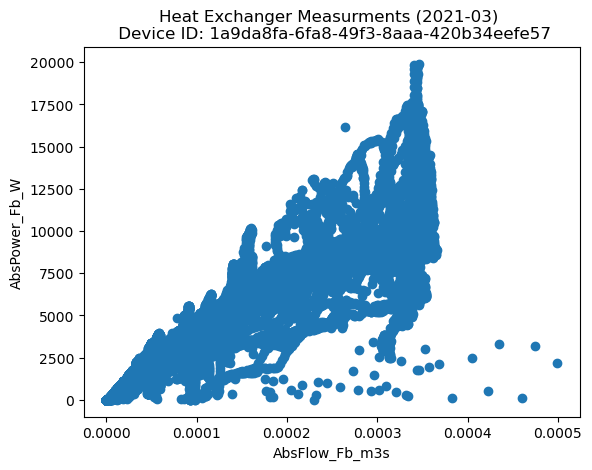

In [17]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

device_id = "1a9da8fa-6fa8-49f3-8aaa-420b34eefe57"
year_month = "202103"
x = "AbsFlow_Fb_m3s"
y = "AbsPower_Fb_W"
df_data = spark.read.format("deltaSharing").load(f"{config}#start_hack_2025.start_hack_2025.ev3_device_data").filter((col("device_id") == device_id) & (col("year_month") == year_month)).toPandas()
year_month = year_month[:4] + '-' + year_month[4:]
plt.scatter(df_data[x], df_data[y])
plt.xlabel(x)
plt.ylabel(y)
plt.title(f"Heat Exchanger Measurments ({year_month}) \n Device ID: {device_id}")
plt.show()

### Table 3
Cloud api logs describing interactions with our cloud.

In [ ]:
df3 = spark.read.format("deltaSharing").load(f"{config}#start_hack_2025.start_hack_2025.cc_api_logs") #.limit(3)

In [9]:
pd_df1.head()

,id,access,basetype,description,format,name,privacy,restriction,definedBy,unit
0,evcloud.00009,r,int,Valve Type,application/vnd.belimo.enum;0|1,ValveType,False,uint8,evcloud/1.2,None
1,evcloud.10,r,int,DN Size of Valve,None,DN_Size,False,int32,evcloud/1.2,None
2,evcloud.100,r,real,Relative Flow in %,None,RelFlow_Fb_Rel2Vmax,False,"[-2147483.648,2147483.647]",evcloud/1.2,percent


In [5]:
top_5_device_ids = df2.groupBy("device_id").count().orderBy("count", ascending=False).limit(5).toPandas()
top_5_device_ids = top_5_device_ids["device_id"].tolist()
top_5_device_ids

['731b216e-64ea-4b77-818d-654dbb488818',
 'f88446ee-5189-4196-867b-cdff22ee852c',
 'c421b7d1-617c-46cb-9463-e0920c2c7c18',
 'fd82ffff-c41b-4641-b829-8b3339a571ff',
 '05e452d6-c0af-4c77-bb5a-75fc26b80861']

In [26]:
df_5_example = df2.filter(df2.device_id.isin(top_5_device_ids))

In [27]:
# only take the rows with datetime between 2021-01-01 and 2021-12-31
from pyspark.sql.functions import to_date, col
df_5_example = df_5_example.withColumn("cloud_received_time", to_date(col("cloud_received_time"), "yyyy-MM-dd HH:mm:ss"))
df_5_example = df_5_example.filter((col("cloud_received_time") >= "2021-01-01") & (col("cloud_received_time") <= "2021-12-31"))

In [28]:
# only keep the columns "device_id", "cloud_received_time", "Heating_E_J", "Cooling_E_J"
df_5_example = df_5_example.select("device_id", "cloud_received_time", "Heating_E_J", "Cooling_E_J")

In [29]:
# create a new column that sums Heating_E_J and Cooling_E_J
df_5_example = df_5_example.withColumn("Heating_Cooling_E_J", col("Heating_E_J") + col("Cooling_E_J"))
df_5_example = df_5_example.select("device_id", "cloud_received_time", "Heating_Cooling_E_J")
# df_5_example = df_5_example.toPandas()

In [30]:
# make the clodd_received_time a datetime
# df_5_example = df_5_example.withColumn("cloud_received_time", to_date(col("cloud_received_time"), "yyyy-MM-dd HH:mm:ss"))
# group by device_id and cloud_received_time and average the Heating_Cooling_E_J
df_5_example = df_5_example.groupBy("device_id", "cloud_received_time").agg({"Heating_Cooling_E_J": "avg"})
df_5_example = df_5_example.withColumnRenamed("avg(Heating_Cooling_E_J)", "Heating_Cooling_E_J")

In [31]:
import pandas as pd

In [32]:
df_5_example_pandas = df_5_example.toPandas()
df_5_example_pandas["cloud_received_time"] = pd.to_datetime(df_5_example_pandas["cloud_received_time"])
df_5_example_pandas = df_5_example_pandas.set_index("cloud_received_time")

In [33]:
df_5_example_pandas_1 = df_5_example_pandas.copy()

In [34]:
df_5_example_pandas_1.head(10)

,device_id,Heating_Cooling_E_J
cloud_received_time,,
2021-09-17,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.846409e+12
2021-09-28,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.959495e+12
2021-09-23,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.907462e+12
2021-09-22,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.897845e+12
2021-09-10,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.773020e+12
2021-09-21,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.887143e+12
2021-09-20,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.875959e+12
2021-09-14,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.815268e+12
2021-09-27,c421b7d1-617c-46cb-9463-e0920c2c7c18,9.949346e+12


In [35]:
# sort the dataframe by cloud_received_time
df_5_example_pandas_1 = df_5_example_pandas_1.sort_values("cloud_received_time")

In [36]:
first_measurement = df_5_example_pandas_1.groupby("device_id")["Heating_Cooling_E_J"].transform("first")

# Compute relative difference
df_5_example_pandas_1["Relative_Heating_Cooling_E_J"] = df_5_example_pandas_1["Heating_Cooling_E_J"] - first_measurement

In [37]:
df_5_example_pandas_1["Daily_Heating_Cooling_E_J"] = df_5_example_pandas_1.groupby("device_id")["Relative_Heating_Cooling_E_J"].diff()

# Fill NaN values with 0 (first entry for each device will be NaN)
df_5_example_pandas_1["Daily_Heating_Cooling_E_J"] = df_5_example_pandas_1["Daily_Heating_Cooling_E_J"].fillna(0)

In [41]:
df_5_example_pandas_1.head(10)

,device_id,Heating_Cooling_E_J,Relative_Heating_Cooling_E_J,Daily_Heating_Cooling_E_J
cloud_received_time,,,,
2021-01-01,731b216e-64ea-4b77-818d-654dbb488818,7.576021e+12,0.000000e+00,0.000000e+00
2021-01-01,f88446ee-5189-4196-867b-cdff22ee852c,1.093727e+13,0.000000e+00,0.000000e+00
2021-01-01,c421b7d1-617c-46cb-9463-e0920c2c7c18,7.168071e+12,0.000000e+00,0.000000e+00
2021-01-01,fd82ffff-c41b-4641-b829-8b3339a571ff,0.000000e+00,0.000000e+00,0.000000e+00
2021-01-01,05e452d6-c0af-4c77-bb5a-75fc26b80861,2.546547e+13,0.000000e+00,0.000000e+00
2021-01-02,05e452d6-c0af-4c77-bb5a-75fc26b80861,2.550364e+13,3.816892e+10,3.816892e+10
2021-01-02,fd82ffff-c41b-4641-b829-8b3339a571ff,0.000000e+00,0.000000e+00,0.000000e+00
2021-01-02,731b216e-64ea-4b77-818d-654dbb488818,7.586911e+12,1.088975e+10,1.088975e+10
2021-01-02,c421b7d1-617c-46cb-9463-e0920c2c7c18,7.178339e+12,1.026817e+10,1.026817e+10


In [44]:
# remove the first date of each device
df_5_example_pandas_1 = df_5_example_pandas_1.reset_index()
df_5_example_pandas_1 = df_5_example_pandas_1[df_5_example_pandas_1["cloud_received_time"] > pd.to_datetime('2021-01-01')]
df_5_example_pandas_1.set_index("cloud_received_time", inplace=True)
df_5_example_pandas_1.head(10)

,index,device_id,Heating_Cooling_E_J,Relative_Heating_Cooling_E_J,Daily_Heating_Cooling_E_J
cloud_received_time,,,,,
2021-01-02,5,05e452d6-c0af-4c77-bb5a-75fc26b80861,2.550364e+13,3.816892e+10,3.816892e+10
2021-01-02,6,fd82ffff-c41b-4641-b829-8b3339a571ff,0.000000e+00,0.000000e+00,0.000000e+00
2021-01-02,7,731b216e-64ea-4b77-818d-654dbb488818,7.586911e+12,1.088975e+10,1.088975e+10
2021-01-02,8,c421b7d1-617c-46cb-9463-e0920c2c7c18,7.178339e+12,1.026817e+10,1.026817e+10
2021-01-02,9,f88446ee-5189-4196-867b-cdff22ee852c,1.095363e+13,1.636477e+10,1.636477e+10
2021-01-03,10,731b216e-64ea-4b77-818d-654dbb488818,7.597771e+12,2.174962e+10,1.085987e+10
2021-01-03,11,c421b7d1-617c-46cb-9463-e0920c2c7c18,7.188462e+12,2.039061e+10,1.012244e+10
2021-01-03,12,05e452d6-c0af-4c77-bb5a-75fc26b80861,2.554181e+13,7.633842e+10,3.816951e+10
2021-01-03,13,f88446ee-5189-4196-867b-cdff22ee852c,1.096993e+13,3.265801e+10,1.629324e+10


In [46]:
# remove the index column
df_5_example_pandas_1.drop(columns=["index"], inplace=True)
df_5_example_pandas_1.head(10)

,device_id,Heating_Cooling_E_J,Relative_Heating_Cooling_E_J,Daily_Heating_Cooling_E_J
cloud_received_time,,,,
2021-01-02,05e452d6-c0af-4c77-bb5a-75fc26b80861,2.550364e+13,3.816892e+10,3.816892e+10
2021-01-02,fd82ffff-c41b-4641-b829-8b3339a571ff,0.000000e+00,0.000000e+00,0.000000e+00
2021-01-02,731b216e-64ea-4b77-818d-654dbb488818,7.586911e+12,1.088975e+10,1.088975e+10
2021-01-02,c421b7d1-617c-46cb-9463-e0920c2c7c18,7.178339e+12,1.026817e+10,1.026817e+10
2021-01-02,f88446ee-5189-4196-867b-cdff22ee852c,1.095363e+13,1.636477e+10,1.636477e+10
2021-01-03,731b216e-64ea-4b77-818d-654dbb488818,7.597771e+12,2.174962e+10,1.085987e+10
2021-01-03,c421b7d1-617c-46cb-9463-e0920c2c7c18,7.188462e+12,2.039061e+10,1.012244e+10
2021-01-03,05e452d6-c0af-4c77-bb5a-75fc26b80861,2.554181e+13,7.633842e+10,3.816951e+10
2021-01-03,f88446ee-5189-4196-867b-cdff22ee852c,1.096993e+13,3.265801e+10,1.629324e+10


In [51]:
# save the dataframe to a csv file
id_to_save = "731b216e-64ea-4b77-818d-654dbb488818"
df_id = df_5_example_pandas_1[df_5_example_pandas_1["device_id"] == id_to_save].drop(columns=["device_id", "Heating_Cooling_E_J", "Relative_Heating_Cooling_E_J"])
df_id.head(10)

,Daily_Heating_Cooling_E_J
cloud_received_time,
2021-01-02,1.088975e+10
2021-01-03,1.085987e+10
2021-01-04,1.076264e+10
2021-01-05,1.075489e+10
2021-01-06,1.097471e+10
2021-01-07,1.092516e+10
2021-01-08,1.096499e+10
2021-01-09,1.099539e+10
2021-01-10,1.081452e+10


In [58]:
# save the dataframe to a csv file
df_id.to_csv(f"{id_to_save.replace('-', '_')}.csv", index=True)

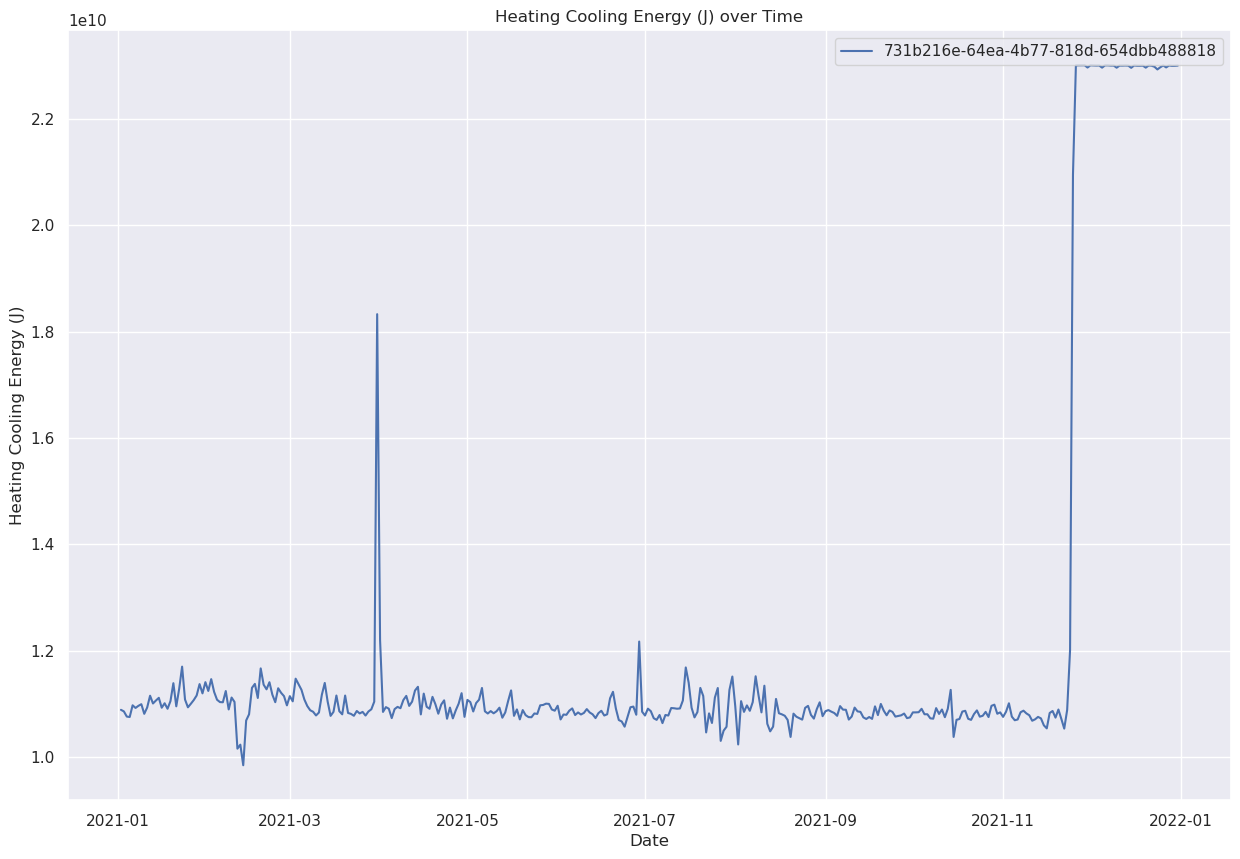

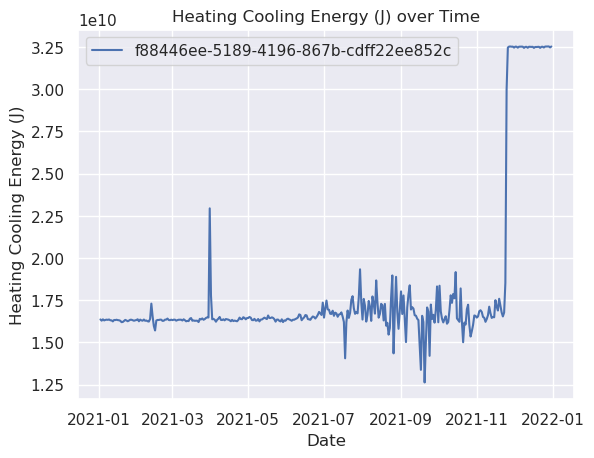

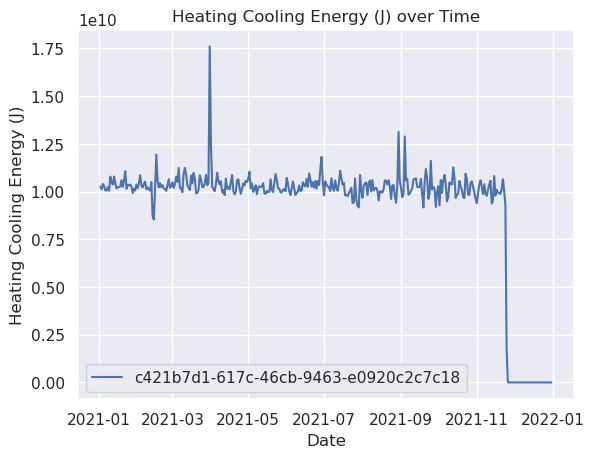

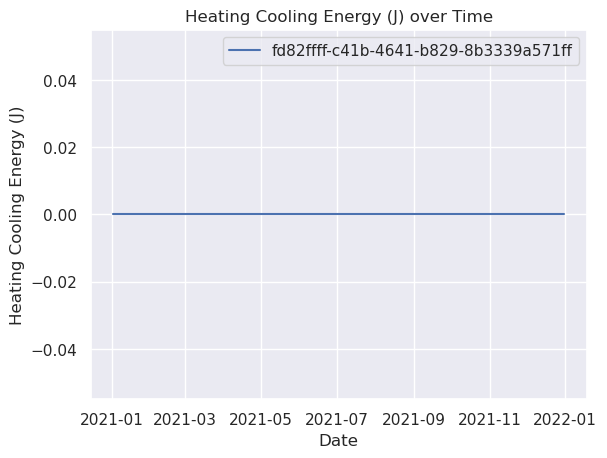

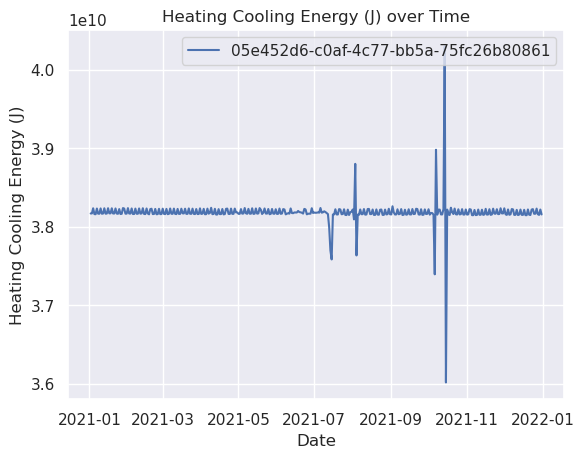

In [45]:
# plot the time series of the different devices
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.figure(figsize=(15, 10))
# do different plots for each device
for device_id in top_5_device_ids:
    df_device = df_5_example_pandas_1[df_5_example_pandas_1["device_id"] == device_id]
    plt.plot(df_device.index, df_device["Daily_Heating_Cooling_E_J"], label=device_id)
    plt.xlabel("Date")
    plt.ylabel("Heating Cooling Energy (J)")
    plt.title("Heating Cooling Energy (J) over Time")
    plt.legend()
    plt.show()

In [ ]:
# plot the time series with respect to a month


# make the cloud_received_time the index
df_5_example_pd = df_5_example.copy()
df_5_example_pd["cloud_received_time"] = pd.to_datetime(df_5_example_pd["cloud_received_time"])
df_5_example_pd.set_index("cloud_received_time", inplace=True)
# resample the data to daily data by mean and std
df_5_example_pd_mean = df_5_example_pd.groupby("device_id").resample("D").mean()
# reset the index
df_5_example_pd.reset_index(inplace=True)

df_5_example_pd.head(10)

In [17]:
# plot the time series of the different devices
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
plt.figure(figsize=(15, 10))
# do different plots for each device
for device_id in df_5_example.device_id.unique():
    df_device = df_5_example[df_5_example.device_id == device_id]
    plt.plot(df_device["cloud_received_time"], df_device["Heating_Cooling_E_J"], label=device_id)
    plt.xlabel("Date")
    plt.ylabel("Heating + Cooling Energy (J)")
    plt.title(f"Heating + Cooling Energy (J) for device {device_id}")
    plt.legend()
    plt.show()


KeyError: 'cloud_received_time'

<Figure size 1500x1000 with 0 Axes>